In [0]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
from sklearn.model_selection import train_test_split
import pandas
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import Normalizer

from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.sparse import hstack
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
import pickle
from tqdm import tqdm
from prettytable import PrettyTable
import plotly.offline as offline
import plotly.graph_objs as go
import seaborn as sn

In [0]:
path_ = ''
data = pandas.read_csv(path_ + 'preprocessed_data.csv')

In [0]:
p_data = data.iloc[0:]
p_data['y_class'] = p_data['project_is_approved']
y = p_data['project_is_approved'].values
x = p_data


<h2>1.2 Splitting data into Train and cross validation(or test): Stratified Sampling</h2>

In [0]:
# please write all the code with proper documentation, and proper titles for each subsection
# go through documentations and blogs before you start coding
# first figure out what to do, and then think about how to do.
# reading and understanding error messages will be very much helpfull in debugging your code
# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label
X_train , X_test , y_train , y_test = train_test_split( x , y , test_size=0.33, stratify=y)
y_category = X_train['project_is_approved'].unique()

In [0]:
#neg: 0.01, neu: 0.745, pos: 0.245, compound: 0.9975

negative = np.zeros_like(y_train)
negative = negative + 0.01
negative = negative.reshape(-1,1)

neu = np.zeros_like(y_train)
neu = neu + 0.745
neu = neu.reshape(-1,1)

pos = np.zeros_like(y_train)
pos = pos + 0.245
pos = pos.reshape(-1,1)

compound = np.zeros_like(y_train)
compound = compound + 0.9975
compound = compound.reshape(-1,1)

negative_test = negative[0: len(y_test)]
neu_test = neu[0: len(y_test)]
pos_test = pos[0: len(y_test)]
compound_test = compound[0: len(y_test)]


In [0]:

def get_response_table( feature_cat , feature_cat_count , y_class ):
  
  feature_response_table = {}

  for idx , cat in enumerate(feature_cat):
    
    probability_of_class = []
    class_0 = 0
    class_1 = 0
    for y_cat in sorted( y_class ,reverse=False):
      tu = (cat , y_cat)
      probability_val = 0
      try :
        row_of_cat = feature_cat_count.loc[ [tu] ]
        
        if y_cat == 0 :
          class_0 = row_of_cat['y_class'].values[0]
        else :
          class_1 = row_of_cat['y_class'].values[0]
      except :
        class_not_avail_for_cat = []
        class_not_avail_for_cat.append(tu)

    if class_0 == 0 and class_1 ==0 :  
      p_0 , p_1 = 0 , 0  
    else :
      p_0 = np.round( class_0 / (class_0 + class_1) , 3 )
      p_1 = np.round( class_1 / (class_0 + class_1) , 3 )
    
    probability_of_class.append( p_0 )
    probability_of_class.append( p_1 )
    feature_response_table[cat] = ( probability_of_class )

  return feature_response_table

def get_encoded_category(response_table , feature_data ):
  
  return  np.array([ response_table.get(i) if response_table.get(i) is not None else [0.5,0.5] for i in feature_data.values ])


In [10]:
# please write all the code with proper documentation, and proper titles for each subsection
# go through documentations and blogs before you start coding
# first figure out what to do, and then think about how to do.
# reading and understanding error messages will be very much helpfull in debugging your code
# make sure you featurize train and test data separatly

# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label

print("*"*100)

tfidf_vec_essay = TfidfVectorizer(min_df=10 , ngram_range=(1,4), max_features=5000 )
tfidf_vec_essay.fit(X_train['essay'].values) 

X_train_essay_tfidf = tfidf_vec_essay.transform(X_train['essay'].values)
X_test_essay_tfidf = tfidf_vec_essay.transform(X_test['essay'].values)

print("After vectorizations")
print(X_train_essay_tfidf.shape, y_train.shape)
print(X_test_essay_tfidf.shape, y_test.shape)
print("="*100)

****************************************************************************************************
After vectorizations
(73196, 5000) (73196,)
(36052, 5000) (36052,)


In [11]:
# please write all the code with proper documentation, and proper titles for each subsection
# go through documentations and blogs before you start coding 
# first figure out what to do, and then think about how to do.
# reading and understanding error messages will be very much helpfull in debugging your code
# make sure you featurize train and test data separatly

# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label


#school_state
#vectorizations
school_state_vec = CountVectorizer(min_df=10, max_features=5000)
school_state_vec.fit( X_train['school_state'].values )
school_state = school_state_vec.transform( X_train['school_state'].values )

school_state_df = X_train[['school_state','y_class','project_is_approved']]
school_state_cat = school_state_vec.get_feature_names() #school_state_df['school_state'].unique()
print(school_state_cat)
school_state_cat_count = school_state_df.groupby(['school_state','project_is_approved']).count()

school_state_response_table = get_response_table(school_state_cat , school_state_cat_count , y_category )

encoded_train_school_state = get_encoded_category(school_state_response_table , X_train['school_state'] )
school_state_test = school_state_vec.transform( X_test['school_state'].values )
encoded_test_school_state = get_encoded_category(school_state_response_table , X_test['school_state'] )
print("After vectorizations")
print(encoded_train_school_state.shape, y_train.shape)
print(encoded_test_school_state.shape, y_test.shape)

#teacher_prefix
#vectorizations
teacher_prefix_vec = CountVectorizer(min_df=10, max_features=5000)
teacher_prefix_vec.fit( X_train['teacher_prefix'].values)
teacher_prefix = teacher_prefix_vec.transform( X_train['teacher_prefix'].values )

teacher_prefix_df = X_train[['teacher_prefix','y_class','project_is_approved']]
teacher_prefix_cat = teacher_prefix_vec.get_feature_names() #teacher_prefix_df['teacher_prefix'].unique()
teacher_prefix_cat_count = teacher_prefix_df.groupby(['teacher_prefix','project_is_approved']).count()

feature_response_table = get_response_table(teacher_prefix_cat , teacher_prefix_cat_count , y_category )
encoded_train_teacher_prefix = get_encoded_category(feature_response_table , X_train['teacher_prefix'] )
teacher_prefix_test = teacher_prefix_vec.transform( X_test['teacher_prefix'].values )
encoded_test_teacher_prefix = get_encoded_category(feature_response_table , X_test['teacher_prefix'] )
print("After vectorizations")
print(encoded_train_teacher_prefix.shape, y_train.shape)
print(encoded_test_teacher_prefix.shape, y_test.shape)

#project_grade_category
#vectorizations
project_grade_category_vec = CountVectorizer(min_df=10, max_features=5000)
project_grade_category_vec.fit( X_train['project_grade_category'].values )
project_grade_category = project_grade_category_vec.transform( X_train['project_grade_category'].values )

project_grade_category_df = X_train[['project_grade_category','y_class','project_is_approved']]
project_grade_category_cat = project_grade_category_vec.get_feature_names() #project_grade_category_df['project_grade_category'].unique()
project_grade_category_cat_count = project_grade_category_df.groupby(['project_grade_category','project_is_approved']).count()

project_grade_category_response_table = get_response_table(project_grade_category_cat , project_grade_category_cat_count , y_category )

encoded_train_project_grade_category = get_encoded_category(project_grade_category_response_table , X_train['project_grade_category'] )
project_grade_category_test = project_grade_category_vec.transform( X_test['project_grade_category'].values )
encoded_test_project_grade_category = get_encoded_category(project_grade_category_response_table , X_test['project_grade_category'] )
print("After vectorizations")
print(encoded_train_project_grade_category.shape, y_train.shape)
print(encoded_test_project_grade_category.shape, y_test.shape)
#clean_categories
#vectorizations
clean_categories_vec = CountVectorizer(min_df=10, max_features=5000)
clean_categories_vec.fit( X_train['clean_categories'].values )
clean_categories = clean_categories_vec.transform( X_train['clean_categories'].values )

clean_categories_df = X_train[['clean_categories','y_class','project_is_approved']]
clean_categories_cat = clean_categories_vec.get_feature_names() #clean_categories_df['clean_categories'].unique()
clean_categories_cat_count = clean_categories_df.groupby(['clean_categories','project_is_approved']).count()

clean_categories_response_table = get_response_table(clean_categories_cat , clean_categories_cat_count , y_category )

encoded_train_clean_categories = get_encoded_category(clean_categories_response_table , X_train['clean_categories'] )
clean_categories_test = clean_categories_vec.transform( X_test['clean_categories'].values )
encoded_test_clean_categories = get_encoded_category(clean_categories_response_table , X_test['clean_categories'] )
print("After vectorizations")
print(encoded_train_clean_categories.shape, y_train.shape)
print(encoded_test_clean_categories.shape, y_test.shape)

#clean_subcategories
#vectorizations
clean_subcategories_vec = CountVectorizer(min_df=10, max_features=5000)
clean_subcategories_vec.fit( X_train['clean_subcategories'].values )
clean_subcategories = clean_subcategories_vec.transform( X_train['clean_subcategories'].values )

clean_subcategories_df = X_train[['clean_subcategories','y_class','project_is_approved']]
clean_subcategories_cat = clean_subcategories_vec.get_feature_names() #clean_subcategories_df['clean_subcategories'].unique()
clean_subcategories_cat_count = clean_subcategories_df.groupby(['clean_subcategories','project_is_approved']).count()

clean_subcategories_response_table = get_response_table(clean_subcategories_cat , clean_subcategories_cat_count , y_category )

encoded_train_clean_subcategories = get_encoded_category(clean_subcategories_response_table , X_train['clean_subcategories'] )
clean_subcategories_test = clean_subcategories_vec.transform( X_test['clean_subcategories'].values )
encoded_test_clean_subcategories = get_encoded_category(clean_subcategories_response_table , X_test['clean_subcategories'] )
print("After vectorizations")
print(encoded_train_clean_subcategories.shape, y_train.shape)
print(encoded_test_clean_subcategories.shape, y_test.shape)

#price
normalizer_p = Normalizer()

normalizer_p.fit(X_train['price'].values.reshape(-1,1))

X_train_price_norm = normalizer_p.transform(X_train['price'].values.reshape(-1,1))
X_test_price_norm = normalizer_p.transform(X_test['price'].values.reshape(-1,1))

#teacher_number_of_previously_posted_projects
normalizer = Normalizer()

normalizer.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

X_train_teacher_no_norm = normalizer.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_test_teacher_no_norm = normalizer.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

#Final Data matrix
X_tr = hstack((X_train_essay_tfidf , encoded_train_school_state , encoded_train_teacher_prefix , \
               encoded_train_project_grade_category, encoded_train_clean_categories ,encoded_train_clean_subcategories, \
               negative , neu ,pos , compound , \
               X_train_price_norm , X_train_teacher_no_norm )).tocsr()

X_te = hstack((X_test_essay_tfidf , encoded_test_school_state , encoded_test_teacher_prefix , \
          encoded_test_project_grade_category, encoded_test_clean_categories , encoded_test_clean_subcategories , \
          negative_test , neu_test ,pos_test, compound_test , \
          X_test_price_norm , X_test_teacher_no_norm)).tocsr()

print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_te.shape, y_test.shape)
print("="*100)


['ak', 'al', 'ar', 'az', 'ca', 'co', 'ct', 'dc', 'de', 'fl', 'ga', 'hi', 'ia', 'id', 'il', 'in', 'ks', 'ky', 'la', 'ma', 'md', 'me', 'mi', 'mn', 'mo', 'ms', 'mt', 'nc', 'nd', 'ne', 'nh', 'nj', 'nm', 'nv', 'ny', 'oh', 'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn', 'tx', 'ut', 'va', 'vt', 'wa', 'wi', 'wv', 'wy']
After vectorizations
(73196, 2) (73196,)
(36052, 2) (36052,)
After vectorizations
(73196, 2) (73196,)
(36052, 2) (36052,)
After vectorizations
(73196, 2) (73196,)
(36052, 2) (36052,)
After vectorizations
(73196, 2) (73196,)
(36052, 2) (36052,)
After vectorizations
(73196, 2) (73196,)
(36052, 2) (36052,)
Final Data matrix
(73196, 5016) (73196,)
(36052, 5016) (36052,)


In [0]:
# please write all the code with proper documentation, and proper titles for each subsection
# go through documentations and blogs before you start coding
# first figure out what to do, and then think about how to do.
# reading and understanding error messages will be very much helpfull in debugging your code
# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label
def batch_predict(clf, data):
    y_data_pred = []
    tr_loop = data.shape[0] - data.shape[0]%1000
    
    for i in range(0, tr_loop, 1000):
        y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])
    
    if data.shape[0]%1000 !=0:
        y_data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1])
    
    return y_data_pred

In [0]:
#Train Data
xgboost = XGBClassifier(objective='binary:logistic'  )

parameters = {"learning_rate" : [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3] ,
              "n_estimators": [5,10,50, 75, 100] }

clf = RandomizedSearchCV( xgboost , parameters, cv=3, scoring='roc_auc' , return_train_score=True)
clf.fit(X_tr, y_train)

results = pandas.DataFrame.from_dict(clf.cv_results_)

# find n_estimators , learning_rate, auc
train_auc= sorted(results['mean_train_score'])
params =  results['params']
n_estimators = sorted([i['n_estimators'] for i in params])
learning_rate = sorted([i['learning_rate'] for i in params])

In [0]:
#Test Data

parameters = {"learning_rate" : [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3] ,
              "n_estimators": [5,10,50, 75, 100] }

clf_test = RandomizedSearchCV( XGBClassifier(objective='binary:logistic'  ) \
                              , parameters, cv=3, scoring='roc_auc' , return_train_score=True)
clf_test.fit(X_te, y_test)

results_test = pandas.DataFrame.from_dict(clf_test.cv_results_)

# find test_n_estimators , learning_rate, test_auc
test_auc= sorted(results_test['mean_train_score'])
test_params =  results_test['params']
test_n_estimators = sorted([i['n_estimators'] for i in test_params])
test_learning_rate = sorted([i['learning_rate'] for i in test_params])

In [0]:
#https://stackoverflow.com/questions/56277838/using-plotly-in-offline-mode-in-google-colab
#To display Scatter3d plot
def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-1.5.1.min.js?noext',
            },
          });
        </script>
        '''))

In [35]:

offline.init_notebook_mode(connected=True)

configure_plotly_browser_state()

trace1 = go.Scatter3d(x= n_estimators ,y=  learning_rate ,z= train_auc, name = 'Train data' \
  ,mode = 'markers', marker = dict(
      size = 10,
      color = 'green', 
      colorscale = 'Viridis'
      )
  )
trace2 = go.Scatter3d(x= test_n_estimators , y= test_learning_rate , z= test_auc, name = 'Test data'
  ,mode = 'markers', marker = dict(
      size = 10,
      color = 'orange', 
      colorscale = 'Viridis'
      ))

layout = go.Layout(title = '3D Scatter plot')

fig = go.Figure(data=[trace1 , trace2], layout=layout)
offline.iplot(fig)

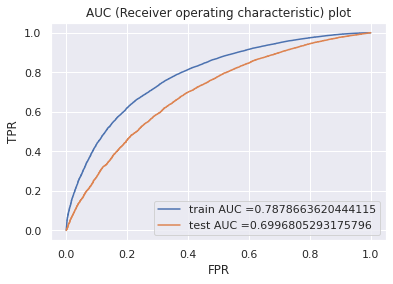

In [46]:
# Reference : Assignment-11 ( Decision Tree )
tuned_n_estimators_tfidf = 100
tuned_learning_rate_tfidf = 0.3

xg_boost = XGBClassifier(objective='binary:logistic',n_estimators=tuned_n_estimators_tfidf, learning_rate= tuned_learning_rate_tfidf  )
xg_boost.fit(X_tr, y_train)

y_train_pred = batch_predict( xg_boost, X_tr )
y_test_pred = batch_predict( xg_boost, X_te )

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

auc_for_tfidf = auc(train_fpr, train_tpr)
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("AUC (Receiver operating characteristic) plot")
plt.grid("whitegrid")
plt.show()

the maximum value of tpr*(1-fpr) 0.5127457541558215 for threshold 0.829
Train confusion matrix
[[ 7673  3410]
 [16111 46002]]


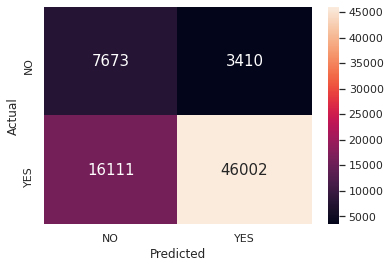

****************************************************************************************************
Test confusion matrix
[[ 3138  2321]
 [ 8589 22004]]


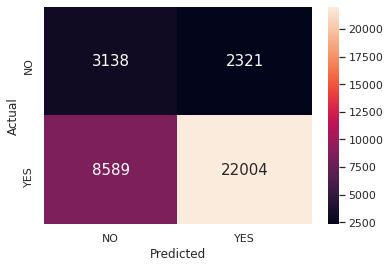

In [47]:
# Reference :( Decision Tree )

def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

def confusion_matrix_heatmap( conf_matrix ):
  matrix_params = [ "NO" , "YES" ]
  df_cm = pandas.DataFrame( conf_matrix  , matrix_params , matrix_params )
  df_cm.index.name = 'Actual'
  df_cm.columns.name = 'Predicted'
  sn.set(font_scale=1.0)
  sn.heatmap(df_cm, annot=True,fmt='d', annot_kws={"size": 15})
  plt.show()


print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
train_conf_matrix = confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
print(train_conf_matrix)
confusion_matrix_heatmap(train_conf_matrix)
print("*"*100)
print("Test confusion matrix")
test_conf_matrix = confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))
print(test_conf_matrix)
confusion_matrix_heatmap(test_conf_matrix)

In [0]:
glove_path_ = ''

with open( glove_path_ + 'glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())


def compute_TFIDF_W2V(preprocessed_data):

  tfidf_model = TfidfVectorizer()
  tfidf_model.fit(preprocessed_data)
  # we are converting a dictionary with word as a key, and the idf as a value
  dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
  tfidf_words = set(tfidf_model.get_feature_names())
  # compute average word2vec for each review.
  tfidf_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
  for sentence in tqdm(preprocessed_data): # for each review/sentence
      vector = np.zeros(300) # as word vectors are of zero length
      tf_idf_weight =0; # num of words with a valid vector in the sentence/review
      for word in sentence.split(): # for each word in a review/sentence
          if (word in glove_words) and (word in tfidf_words):
              vec = model[word] # getting the vector for each word
              # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
              tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
              vector += (vec * tf_idf) # calculating tfidf weighted w2v
              tf_idf_weight += tf_idf
      if tf_idf_weight != 0:
          vector /= tf_idf_weight
      tfidf_w2v_vectors.append(vector)
  
  return np.array(tfidf_w2v_vectors)

In [49]:
print("Before vectorizations")
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print("*"*100)

print("Data model for Essay")
X_train_essay_tfidfw2v = compute_TFIDF_W2V(X_train['essay'].values)
X_test_essay_tfidfw2v = compute_TFIDF_W2V(X_test['essay'].values)

print("After vectorizations")
print(X_train_essay_tfidfw2v.shape, y_train.shape)
print(X_test_essay_tfidfw2v.shape, y_test.shape)
print("="*100)


X_tr_tfidfw2v = np.hstack(( X_train_essay_tfidfw2v , encoded_train_school_state , encoded_train_teacher_prefix , \
               encoded_train_project_grade_category, encoded_train_clean_categories ,encoded_train_clean_subcategories, \
               negative , neu ,pos , compound , \
               X_train_price_norm , X_train_teacher_no_norm ))

X_te_tfidfw2v = np.hstack(( X_test_essay_tfidfw2v , encoded_test_school_state , encoded_test_teacher_prefix , \
          encoded_test_project_grade_category, encoded_test_clean_categories , encoded_test_clean_subcategories , \
          negative_test , neu_test ,pos_test, compound_test , \
          X_test_price_norm , X_test_teacher_no_norm))

print("Final Data matrix")
print(X_tr_tfidfw2v.shape, y_train.shape)
print(X_te_tfidfw2v.shape, y_test.shape)
print("="*100)


Before vectorizations
(73196, 10) (73196,)
(36052, 10) (36052,)
****************************************************************************************************
Data model for Essay


100%|██████████| 36052/36052 [01:14<00:00, 482.32it/s]


After vectorizations
(73196, 300) (73196,)
(36052, 300) (36052,)
Final Data matrix
(73196, 316) (73196,)
(36052, 316) (36052,)


In [0]:
#Train Data

parameters = {"learning_rate" : [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3] ,
              "n_estimators": [5,10,50, 75, 100] }

clf_w2v = RandomizedSearchCV( XGBClassifier(objective='binary:logistic'  ) \
                              , parameters, cv=3, scoring='roc_auc' , return_train_score=True)
clf_w2v.fit( X_tr_tfidfw2v , y_train)

results_w2v = pandas.DataFrame.from_dict(clf_w2v.cv_results_)

train_auc_w2v= sorted(results_w2v['mean_train_score'])
train_params_w2v =  results_w2v['params']
train_n_estimators_w2v = sorted([i['n_estimators'] for i in train_params_w2v])
train_learning_rate_w2v = sorted([i['learning_rate'] for i in train_params_w2v])

In [0]:
#test data

parameters = {"learning_rate" : [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3] ,
              "n_estimators": [5,10,50, 75, 100] }              

clf_w2v_te = RandomizedSearchCV( XGBClassifier(objective='binary:logistic'  ) \
                              , parameters, cv=3, scoring='roc_auc' , return_train_score=True)
clf_w2v_te.fit( X_te_tfidfw2v , y_test )

results_w2v_te = pandas.DataFrame.from_dict(clf_w2v_te.cv_results_)

test_auc_w2v= sorted(results_w2v_te['mean_train_score'])
test_params_w2v =  results_w2v_te['params']
test_n_estimators_w2v = sorted([i['n_estimators'] for i in test_params_w2v])
test_learning_rate_w2v = sorted([i['learning_rate'] for i in test_params_w2v])

In [50]:
offline.init_notebook_mode(connected=True)

configure_plotly_browser_state()

trace1 = go.Scatter3d(x= train_n_estimators_w2v ,y=  train_learning_rate_w2v ,z= train_auc_w2v , name = 'Train data' \
  ,mode = 'markers', marker = dict(
      size = 10,
      color = 'green', 
      colorscale = 'Viridis'
      )
  )
trace2 = go.Scatter3d(x= test_n_estimators_w2v , y= test_learning_rate_w2v , z= test_auc_w2v , name = 'Test data'
  ,mode = 'markers', marker = dict(
      size = 10,
      color = 'orange', 
      colorscale = 'Viridis'
      ))

layout = go.Layout(title = '3D Scatter plot')

fig = go.Figure(data=[trace1 , trace2], layout=layout)
offline.iplot(fig)

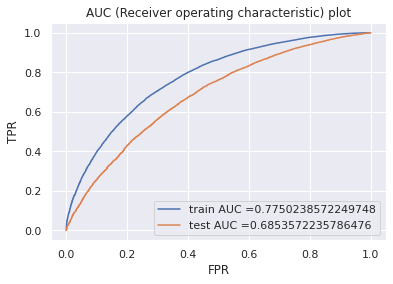

In [52]:
tuned_n_estimators_w2v = 100
tuned_learning_rate_w2v = 0.3

xgboost_w2v = XGBClassifier(objective='binary:logistic',n_estimators= tuned_n_estimators_w2v , learning_rate= tuned_learning_rate_w2v  )
xgboost_w2v.fit( X_tr_tfidfw2v , y_train)

y_train_pred = batch_predict(xgboost_w2v, X_tr_tfidfw2v )
y_test_pred = batch_predict(xgboost_w2v, X_te_tfidfw2v )

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

auc_for_tfidf_w2v = auc(train_fpr, train_tpr)
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("AUC (Receiver operating characteristic) plot")
plt.grid("whitegrid")
plt.show()

the maximum value of tpr*(1-fpr) 0.4950118498172698 for threshold 0.84
Train confusion matrix
[[ 7889  3194]
 [18918 43195]]


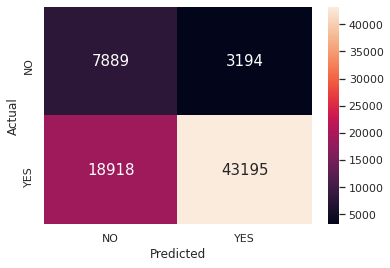

****************************************************************************************************
Test confusion matrix
[[ 3262  2197]
 [ 9918 20675]]


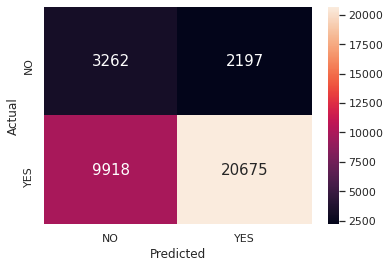

In [53]:
print("="*100)
from sklearn.metrics import confusion_matrix
best_t_w2v = find_best_threshold(tr_thresholds, train_fpr, train_tpr)

print("Train confusion matrix")
tr_conf_matrix = confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t_w2v ))
print( tr_conf_matrix )
confusion_matrix_heatmap( tr_conf_matrix )

print("*"*100)
print("Test confusion matrix")
te_conf_matrix = confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t_w2v ))
print( te_conf_matrix )
confusion_matrix_heatmap( te_conf_matrix )

In [54]:
from prettytable import PrettyTable

t = PrettyTable(['Vectorizer', 'Model','Hyper parameter (n_estimators)','Hyper parameter (learning_rate)','AUC'])

t.add_row(['TFIDF', 'GBDT (xgboost)', tuned_n_estimators_tfidf , tuned_learning_rate_tfidf , round( auc_for_tfidf , 3 )])
t.add_row(['TFIDF-W2V', 'GBDT (xgboost)', tuned_n_estimators_w2v ,tuned_learning_rate_w2v, np.round(auc_for_tfidf_w2v , 3 )])
print(t)

+------------+----------------+--------------------------------+---------------------------------+-------+
| Vectorizer |     Model      | Hyper parameter (n_estimators) | Hyper parameter (learning_rate) |  AUC  |
+------------+----------------+--------------------------------+---------------------------------+-------+
|   TFIDF    | GBDT (xgboost) |              100               |               0.3               | 0.788 |
| TFIDF-W2V  | GBDT (xgboost) |              100               |               0.3               | 0.775 |
+------------+----------------+--------------------------------+---------------------------------+-------+
